In [1]:
import cv2
import cupy as cp
import matplotlib.pyplot as plt
from skimage import img_as_float, restoration

In [2]:
def fast_iterative_denoising_btb(y, f, mu_sequence, T, delta):
    """
    Fast Iterative Denoising Algorithm (BTB)

    Parameters:
        y: Input image (noisy)
        f: Denoiser function
        mu_sequence: Sequence of step sizes
        T: Maximum number of iterations
        delta: Convergence threshold

    Returns:
        x_denoised: Denoised image
    """
    x_prev = cp.asarray(y.copy())  # Initialize previous denoised image as noisy image
    
    for t in range(T):
        x_next = f(x_prev)  # Apply denoiser function to previous denoised image
        
        # Update current denoised image using hybrid Banach contraction principle
        x_current = (1 - mu_sequence[t]) * x_prev + mu_sequence[t] * x_next
        
        # Check convergence criterion
        if cp.linalg.norm(x_current - x_prev) < delta:
            break  # Stop iteration if convergence criterion is met
        
        x_prev = x_current  # Update previous denoised image
        
    return x_current



def add_gaussian_noise(image, sigma):
    """
    Add Gaussian noise to an image

    Parameters:
        image: Input image
        sigma: Standard deviation of Gaussian noise

    Returns:
        image_noisy: Noisy image
    """
    noise = cp.random.normal(0, sigma, image.shape)  # Generate Gaussian noise
    image_noisy = image + noise  # Add noise to image
    image_noisy = cp.clip(image_noisy, 0, 1)  # Clip noisy image to [0, 1]
    
    return image_noisy


In [3]:
img_path = "d:\\synthetic\\seismic_data__I_3.png"

image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cp.asarray(image)

noise = add_gaussian_noise(image, 0.1)

noisy_image = image + cp.asarray(noise).astype(cp.uint8)  # Convert noise to uint8 before adding
noisy_image = img_as_float(cp.asnumpy(noisy_image))

In [4]:
def denoiser_nlm(image):
    # Convert CuPy array to NumPy array
    image_np = cp.asnumpy(image)
    
    # Apply the denoising function on the NumPy array
    denoised_np = restoration.denoise_nl_means(image_np, h=0.1, sigma=0.1, fast_mode=True, patch_size=5, patch_distance=6)
    
    # Convert the denoised NumPy array back to a CuPy array
    denoised_cp = cp.asarray(denoised_np)
    
    return denoised_cp


In [5]:
# Define sequence of step sizes (you can adjust this based on experimentation)
mu_sequence = cp.linspace(0.1, 0.1, 8)

T = 8
delta = 1e-4

# Apply the Fast Iterative Denoising Algorithm (BTB)
denoised_image = fast_iterative_denoising_btb(noisy_image, denoiser_nlm, mu_sequence, T, delta)


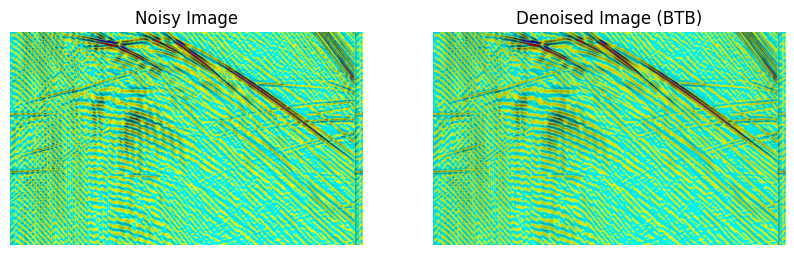

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cp.asnumpy(noisy_image), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cp.asnumpy(denoised_image), cmap='gray')
plt.title('Denoised Image (BTB)')
plt.axis('off')

plt.show()